In [1]:
# From https://nextjournal.com/gkoehler/pytorch-mnist

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np 

In [2]:
device = torch.device('mps')

transform = transforms.Compose([
        transforms.ToTensor()
    ])

train_dataset = torchvision.datasets.MNIST(
    '~/ML/data/', 
    train=True, 
    download=True,
    transform=transform,
)
train_dataset.data.to(device)
train_dataset.targets.to(device)

test_dataset = torchvision.datasets.MNIST(
    '~/ML/data/',
    train=False,
    download=True,
    transform=transform
)
test_dataset.data.to(device)
test_dataset.targets.to(device)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1024, shuffle=True 
)

In [3]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1024, 1, 28, 28])

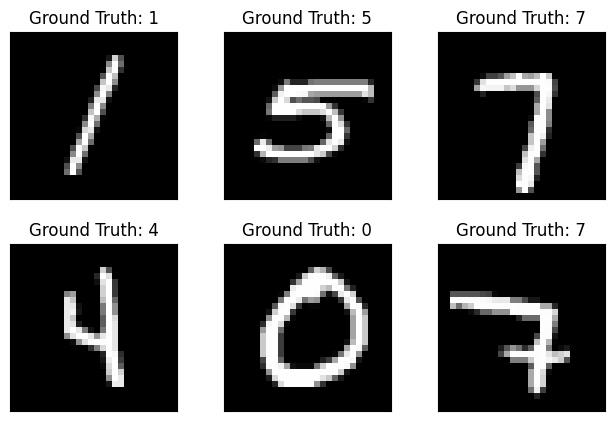

In [56]:
import matplotlib.pyplot as plt

def plotImages(n, data, targets, pred=None):
    fig = plt.figure()
    ncols = 3
    nrows = n//ncols
    for i in range(n):
      plt.subplot(nrows, ncols,i+1)
      plt.tight_layout()
      plt.imshow(data[i][0], cmap='gray', interpolation='none')
      if pred != None:
        plt.title("Ground Truth: {}| Pred:{}".format(targets[i], pred[i]))
      else:
        plt.title("Ground Truth: {}".format(targets[i]))
      plt.xticks([])
      plt.yticks([])
    fig
    
plotImages(6, example_data, example_targets)

In [6]:
# torch.nn are layers with trainable parameters
# torch.nn.functional are purely functional

class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        input_dim = 28
        kernel_size = 5
        last_conv_out = ((input_dim - kernel_size + 1)/2 - kernel_size+1)/2
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5),
            nn.Dropout2d(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features=int(pow(last_conv_out,2)*20), out_features=50, bias=True),
            nn.Linear(in_features=50, out_features=10, bias=True)
        )
        
    def forward(self, x):
        x = self.net(x)
        return F.log_softmax(x, dim =1)
    
network = MNISTNet().to(device)
learning_rate = 0.01
momentum = 0.5
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [8]:
train_log_batch = 100
def train(epoch):
    network.train() # Required for dropout
    total_loss = 0
    count = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.to(device)
        optimizer.zero_grad()
        output = network(data.to(device))
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count+=target.shape[0]

        if (batch_idx+1) % train_log_batch == 0:
            print("\tTrain Batch: {} Loss: {:.6f}".format(batch_idx+1, total_loss/count))
            
    print('Train Epoch: {} Loss: {:.6f}\n'.format(epoch, total_loss/count))


In [4]:
def test():
    network.eval() 
    total_loss = 0
    total_correct = 0
    count = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        target=target.to(device)
        output = network(data.to(device))
        loss = F.nll_loss(output, target)
        total_loss += loss.item()
        
        pred = output.data.max(1).indices
        total_correct += (pred == target).sum()
        
        
        count+=target.shape[0]
    print('Test Accuracy: {:.4f}, Loss: {:.6f}\n'.format(total_correct/count*100, total_loss/count))

In [7]:
import timeit
timeit.timeit(lambda: test(), number=1 )

Test Accuracy: 10.8500, Loss: 0.002265



2.000019458002498

In [33]:
n_epoch=5
test()
for epoch in range(1, n_epoch+1):
    train(epoch)
    test()

Test Accuracy: 8.4633, Loss: 0.002274

	Train Batch: 100 Loss: 0.034937
	Train Batch: 200 Loss: 0.029394
	Train Batch: 300 Loss: 0.023182
	Train Batch: 400 Loss: 0.019379
	Train Batch: 500 Loss: 0.016965
	Train Batch: 600 Loss: 0.015192
	Train Batch: 700 Loss: 0.013854
	Train Batch: 800 Loss: 0.012813
	Train Batch: 900 Loss: 0.011996
Train Epoch: 1 Loss: 0.011721

Test Accuracy: 92.3317, Loss: 0.000254

	Train Batch: 100 Loss: 0.004897
	Train Batch: 200 Loss: 0.004822
	Train Batch: 300 Loss: 0.004760
	Train Batch: 400 Loss: 0.004647
	Train Batch: 500 Loss: 0.004566
	Train Batch: 600 Loss: 0.004483
	Train Batch: 700 Loss: 0.004396
	Train Batch: 800 Loss: 0.004319
	Train Batch: 900 Loss: 0.004267
Train Epoch: 2 Loss: 0.004262

Test Accuracy: 94.8683, Loss: 0.000173

	Train Batch: 100 Loss: 0.003515
	Train Batch: 200 Loss: 0.003588
	Train Batch: 300 Loss: 0.003541
	Train Batch: 400 Loss: 0.003491
	Train Batch: 500 Loss: 0.003474
	Train Batch: 600 Loss: 0.003418
	Train Batch: 700 Loss: 0.0

In [65]:
pred = network(example_data.to(device)).max(1).indices

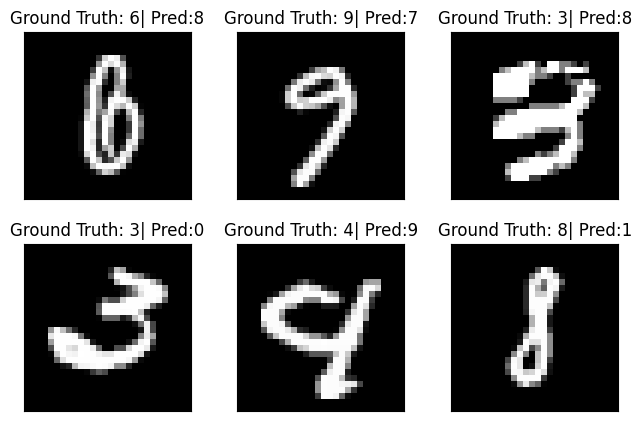

In [67]:
idxs = pred != example_targets.to(device)
plotImages(6, example_data.to(device)[idxs].to('cpu'), example_targets.to(device)[idxs].to('cpu'), pred[idxs].to('cpu'))